## Heart Disease detection using PySpark
In this notebook we will binary classify Heart Diseases patients versus normal patients and try to predict if a persona has a Heart Disease or not.
We use this dataset of Kaggle: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data

### Dependencies

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

### Importing the dataset

In [2]:
# Initialize Spark session
spark = SparkSession.builder.appName("HeartCSVtoPySpark").getOrCreate()

# Load CSV file into DataFrame
df = spark.read.csv('heart.csv', header=True, inferSchema=True)

# Show the DataFrame
df.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|    1.0|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|    0.0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|    0.0|      Up|           0|
| 39|  M|          NAP|      120|        339|        0| 

### Encoding non-numeric features  

In [3]:
# List of categorical columns to be encoded
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Create a StringIndexer for each categorical column
indexers = [StringIndexer(inputCol=column, outputCol=column + "_index") for column in categorical_columns]

# Apply the StringIndexers to the DataFrame
for indexer in indexers:
    df = indexer.fit(df).transform(df)

### Establish features columns and pass it to VectorAssembler
We will use our encoded labels instead of our old labels. VectorAssembler will create a var that will convert all the inputs to an array, we will use it later when fitting the model

In [4]:
# Define the feature columns
feature_columns = ['Age', 'Sex_index', 'ChestPainType_index', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG_index', 'MaxHR', 'ExerciseAngina_index', 'Oldpeak', 'ST_Slope_index']

# Assemble the feature columns into a feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Show the DataFrame with the new indexed columns
df.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+---------+-------------------+----------------+--------------------+--------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|Sex_index|ChestPainType_index|RestingECG_index|ExerciseAngina_index|ST_Slope_index|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+---------+-------------------+----------------+--------------------+--------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|      0.0|                2.0|             0.0|                 0.0|           1.0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|    1.0|    Flat|           1|      1.0|                1.0|             0.0|                 0.0|           

#### Train test split dataset

In [5]:
# Split the DataFrame into training and testing sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Show the number of records in each set
print(f"Training set count: {train_df.count()}")
print(f"Testing set count: {test_df.count()}")

Training set count: 769
Testing set count: 149


### Model
Our model will be a LogisticRegression, the pipeline will be the model and the assembler and we will fit on it the train_df (This will convert the columns we declare previously to a unique array called features for the model to be trained)

In [6]:

# Initialize the Logistic Regression model
lr = LogisticRegression(labelCol="HeartDisease", featuresCol="features")

# Create a pipeline with the assembler and logistic regression model
pipeline = Pipeline(stages=[assembler, lr])

# Train the model
model = pipeline.fit(train_df)

# Print the model summary
print("Model training completed.")

Model training completed.


### Checking model accuracy

In [7]:
# Make predictions on the test dataset
predictions = model.transform(test_df)

# Initialize the evaluator
evaluator = BinaryClassificationEvaluator(labelCol="HeartDisease", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Evaluate the model
accuracy = evaluator.evaluate(predictions)

print(f"Model accuracy (area under ROC): {accuracy}")

Model accuracy (area under ROC): 0.8945603576751113


### Plotting predictions versus Real Output

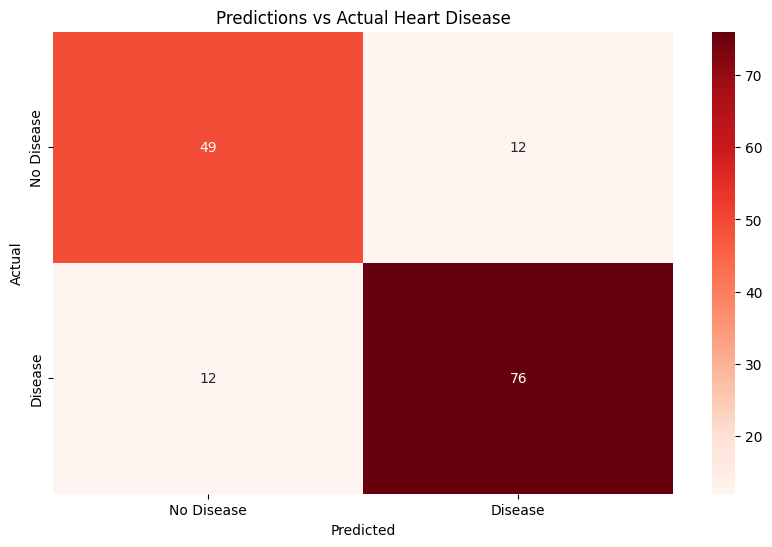

In [8]:
# Convert the relevant columns to a Pandas DataFrame
predictions_pd = predictions.select("prediction", "HeartDisease").toPandas()

# Compute the confusion matrix
cm = confusion_matrix(predictions_pd['HeartDisease'], predictions_pd['prediction'])

# Plot the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predictions vs Actual Heart Disease')
plt.show()

## Conclusion

In this notebook, we successfully built a binary classification model to predict heart disease using PySpark. We followed a structured workflow that included:

1. **Data Import and Exploration**: We imported the heart disease dataset and explored its structure.
2. **Data Preprocessing**: We encoded categorical features using `StringIndexer` and assembled the features into a single vector using `VectorAssembler`.
3. **Model Training**: We split the dataset into training and testing sets and trained a `LogisticRegression` model using a `Pipeline`.
4. **Model Evaluation**: We evaluated the model's performance using the `BinaryClassificationEvaluator` and achieved an accuracy (area under ROC) of approximately 0.895.
5. **Visualization**: We visualized the model's predictions against the actual outcomes using a confusion matrix.

The model demonstrated a good performance in predicting heart disease, as indicated by the high area under the ROC curve. This workflow can be further enhanced by experimenting with different models, feature engineering techniques, and hyperparameter tuning to potentially improve the model's accuracy.